In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tikzplotlib
import os

import scipy.stats as st

In [2]:
scratchHPC = r'\\rb-hpc.de.bosch.com\hro7rng\scratch\MultiPhase'

In [3]:
StudienOrdner = '211012_VOL_150_50Grains_90_95'
StudienOrdner = os.path.join(scratchHPC, StudienOrdner)

In [4]:
lf_csv = r'_eval/lifetime.csv'
lf_csv = os.path.join(StudienOrdner, lf_csv)

In [5]:
df_lf = pd.read_csv(lf_csv)

In [6]:
ll_volf = df_lf['ModelName'].tolist()
ll_volf = [float(kk[kk.rfind('_')+15:])   for kk in ll_volf]

ll_Seed = df_lf['ModelName'].tolist()
ll_Seed = [str(kk[kk.find('_')+5:kk.find('Strain')-1])   for kk in ll_Seed]

In [7]:
minimia_vol = min(ll_volf)
maxima_vol = max(ll_volf)

In [8]:
df_lf['Volume_Martensite'] = ll_volf
df_lf['Seed'] = ll_Seed

df_wholMod = df_lf[df_lf['Phase']=='wholeMod']

In [9]:
norm = matplotlib.colors.Normalize(vmin=minimia_vol, vmax=maxima_vol, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm) 

In [10]:
from scipy import optimize

def tfunktion(x_data, a,b):
    return a*(x_data**2)+b*x_data+x_data


In [11]:
params, params_covariance = optimize.curve_fit(tfunktion, df_wholMod['Lifetime'].tolist(), df_wholMod['StrainAmplitude'].tolist(),)

In [12]:
colorswhole = df_wholMod['Volume_Martensite'].tolist()
un_voll = np.unique(colorswhole)
colorswhole = [float(c) for c in colorswhole]

strain_ll = np.unique(df_wholMod['StrainAmplitude'].tolist())

dic_f_curve = {}
for  vol in un_voll:
    df_red = df_wholMod[df_wholMod['Volume_Martensite']==vol]
    params, params_covariance = optimize.curve_fit(tfunktion, df_red['Lifetime'].tolist(), df_red['StrainAmplitude'].tolist())
    
    ll_mean_lifetimes = [np.min(df_red[df_red['StrainAmplitude']==stra]['Lifetime'].tolist()) for stra in strain_ll]
    print(ll_mean_lifetimes)
    f_curve = [tfunktion(lf, params[0], params[1]) for lf in ll_mean_lifetimes]
    dic_f_curve[vol] = f_curve

print(dic_f_curve)

[30858.90913037375, 1864.7706626996744, 570.1705737777331]
[26212.66515678806, 1419.9676199512426, 313.7381580435187]
{90.0: [0.0042718722761492245, 0.00038922771955185453, 0.0001207994930609857], 95.0: [0.00401476894330699, 0.00031461062576454424, 7.046991993320262e-05]}


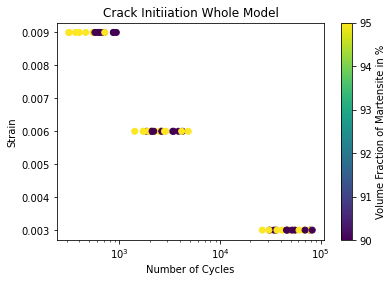

In [13]:

plt.scatter(df_wholMod['Lifetime'], df_wholMod['StrainAmplitude'], c=colorswhole)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Whole Model')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
#plt.show()

tikzplotlib.save(os.path.join(StudienOrdner, 'ScatterLifetimeWholeMod.tex'))
plt.savefig(os.path.join(StudienOrdner, 'ScatterLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

In [14]:
df_Ferrite = df_lf[df_lf['Phase']=='Ferrite']

In [15]:
colorsFerr = df_Ferrite['Volume_Martensite'].tolist()
colorsFerr = [float(c) for c in colorsFerr]

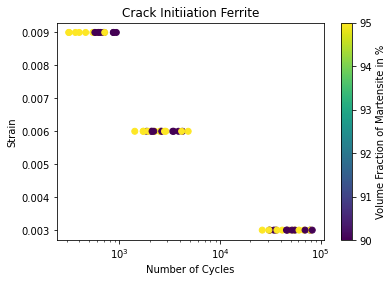

In [16]:
plt.scatter(df_Ferrite['Lifetime'], df_Ferrite['StrainAmplitude'], c=colorsFerr)
cbar = plt.colorbar()
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Ferrite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

In [17]:
df_mart = df_lf[df_lf['Phase']=='Martensite']

In [18]:
colorsMart = df_mart['Volume_Martensite'].tolist()
colorsMart = [int(c) for c in colorsMart]

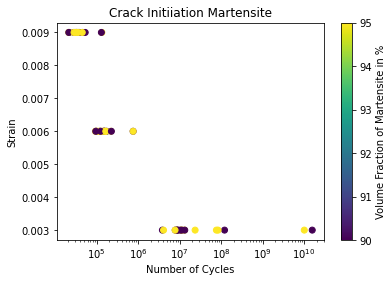

In [19]:
plt.scatter(df_mart['Lifetime'], df_mart['StrainAmplitude'], c=colorsMart)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Martensite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

Abwärts erstelle confidence intervalle

In [20]:
strainll = np.unique(df_wholMod['StrainAmplitude'].tolist())
dic_df_conf = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StrainAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['Lifetime'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_conf[dd] = df_conf

Plotten der confidence Intervalle

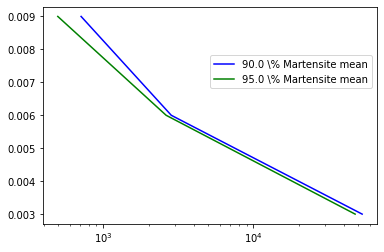

In [21]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['whole']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8))#, ncol=2 )


tikzplotlib.save(os.path.join(StudienOrdner, 'ConfLifetimeWholeMod.tex'))
plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

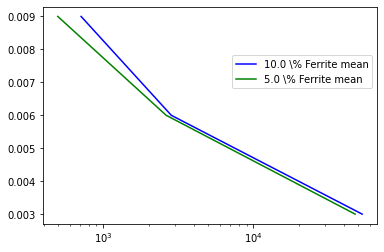

In [22]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Ferrite']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(100-vols)+' \% Ferrite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8))#, ncol=2 )

tikzplotlib.save(os.path.join(StudienOrdner, 'ConfLifetimeFerrite.tex'))
plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeFerrite.png'), bbox_inches='tight', dpi=150, transparent=True)

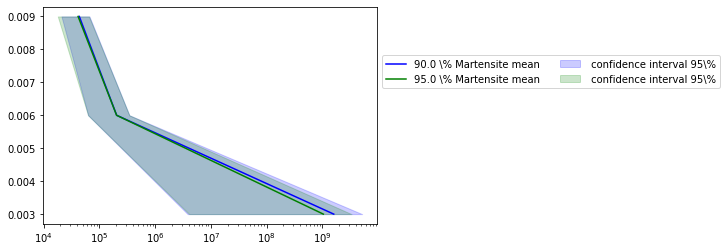

In [23]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Martensite']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8), ncol=2 )


tikzplotlib.save(os.path.join(StudienOrdner, 'ConfLifetimeMartensite.tex'))
plt.savefig(os.path.join(StudienOrdner, 'ConfLifetimeMartensite.png'), bbox_inches='tight', dpi=150, transparent=True)

In [24]:
### AChtung lower bound ist nicht ganz korrekt das dieser durch die große varianz eine negative Lebensdauer angeben würde
### dacher ist in diesen Fällen der Lower Bound = minimum der Lebenszeit für definierte Dehnung und Volumengehalt

In [25]:
mnbv= df_lf[df_lf['StrainAmplitude']==0.009]
mnbv= mnbv[mnbv['Seed']=='93426']
mnbv[mnbv['Volume_Martensite'].isin([95.0,75.0])]

,Unnamed: 0,ModelName,ModelGroup,Lifetime,Phase,_LoadingMode,StrainAmplitude,StrainMean,StressAmplitude,StressMean,FIPmax,FIPmaxLocal,FIPcrit,m_FIP,IsExperimentalData,Volume_Martensite,Seed
15,5.0,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,313.738158,wholeMod,0.0,0.009,0.0,1589.895,-0.045,0.089868,0.225651,2.52124,1.724138,0,95.0,93426
16,5.1,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,30013.228929,Martensite,0.0,0.009,0.0,1589.895,-0.045,0.006433,0.014403,0.82424,2.124313,0,95.0,93426
17,5.2,DisTest_Seed93426_Strain0p9_VolumeFraction95,ALL,313.738158,Ferrite,0.0,0.009,0.0,1589.895,-0.045,0.089868,0.225651,2.52124,1.724138,0,95.0,93426


Bestimme liegt geringste Lebenszeit immer mit Ferrit zusammen? 

In [26]:
#df_lf
ll_model = df_lf['Unnamed: 0'].tolist()

In [27]:
ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = df_lf[df_lf['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        
        for ph in phases:
            if float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime']) == float(ltime):
                ll_prob_phase.append([len(phases),df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]])        

print(np.unique(ll_prob_phase,axis=0))

[['2' 'Ferrite']]


In [28]:
ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = df_lf[df_lf['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        ltime = 9e300
        phaseprob = ''
        for ph in phases:
            if float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime']) < ltime:
                ltime = float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime'])
                phaseprob = df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]
        ll_prob_phase.append([len(phases),phaseprob])        

print(np.unique(ll_prob_phase,axis=0))

[['2' 'Ferrite']]


In [29]:
strainll = np.unique(df_wholMod['StrainAmplitude'].tolist())
dic_df_StressAmp = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StrainAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['StressAmplitude'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_StressAmp[dd] = df_conf

Plotten confidence Intervalle bezogen auf Stress::

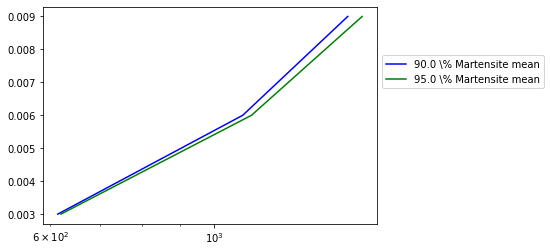

In [30]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']

df_conf = dic_df_StressAmp['whole']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8), ncol=1 )


tikzplotlib.save(os.path.join(StudienOrdner, 'StressAmplitude.tex'))
plt.savefig(os.path.join(StudienOrdner, 'StressAmplitude.png'), bbox_inches='tight', dpi=150, transparent=True)

In [31]:
df_conf

,StrainAmplitude,l_bound VolF 90.0,mean VolF 90.0,u_bound VolF 90.0,l_bound VolF 95.0,mean VolF 95.0,u_bound VolF 95.0
0,0.003,613.767465,614.44215,615.116835,619.798088,620.45785,621.117612
1,0.006,1092.229492,1094.05200,1095.874508,1122.881744,1124.31000,1125.738256
2,0.009,1515.073181,1518.12600,1521.178819,1585.644675,1587.84150,1590.038325


Erstelle VGL

In [32]:
StudienOrdner_dif = '211012_VOL_190_10Grains_90_95'
StudienOrdner_dif = os.path.join(scratchHPC, StudienOrdner)
lf_csv_dif = r'_eval/lifetime.csv'
lf_csv_dif = os.path.join(StudienOrdner, lf_csv)
df_lf_dif = pd.read_csv(lf_csv_dif)

In [33]:
ll_volf_dif = df_lf_dif['ModelName'].tolist()
ll_volf_dif = [float(kk[kk.rfind('_')+15:])   for kk in ll_volf_dif]

ll_Seed_dif = df_lf_dif['ModelName'].tolist()
ll_Seed_dif = [str(kk[kk.find('_')+5:kk.find('Strain')-1])   for kk in ll_Seed_dif]

In [34]:
df_lf_dif['Volume_Martensite'] = ll_volf_dif
df_lf_dif['Seed'] = ll_Seed_dif

df_wholMod_dif = df_lf_dif[df_lf_dif['Phase']=='wholeMod']
df_Ferrite_dif_dif = df_lf_dif[df_lf_dif['Phase']=='Ferrite']
df_mart_dif = df_lf_dif[df_lf_dif['Phase']=='Martensite']

In [35]:
strainll_dif = np.unique(df_wholMod_dif['StrainAmplitude'].tolist())
dic_df_conf_dif = {}
ch_df_dif = {'whole': df_wholMod_dif, 'Ferrite': df_Ferrite_dif_dif, 'Martensite': df_mart_dif}
dd_ll_dif = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf_dif = pd.DataFrame({'StrainAmplitude': strainll_dif})
    for vols in np.unique(ll_volf_dif):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll_dif:
            rdf = ch_df_dif[dd][ch_df_dif[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StrainAmplitude'] == strain]
            a = rdf['Lifetime'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf_dif['l_bound VolF '+ str(vols)] = l_bound
        df_conf_dif['mean VolF '+ str(vols)] = mean
        df_conf_dif['u_bound VolF '+ str(vols)] = u_bound
    dic_df_conf_dif[dd] = df_conf_dif

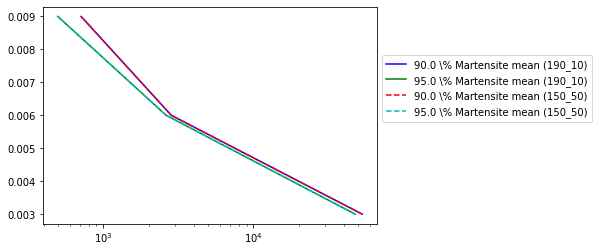

In [43]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf_dif = dic_df_conf_dif['whole']
for num, vols in enumerate(np.unique(ll_volf_dif)):
    plt.plot(df_conf_dif['mean VolF ' + str(vols)],df_conf_dif['StrainAmplitude'], label= (str(vols)+' \% Martensite mean (190_10)'), color=colorlist[num])
    #plt.fill_betweenx(df_conf_dif['StrainAmplitude'], df_conf_dif['l_bound VolF ' + str(vols)], df_conf_dif['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')

df_conf = dic_df_conf['whole']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StrainAmplitude'], linestyle='--',label= (str(vols)+' \% Martensite mean (150_50)'), color=colorlist[num+2])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num+2], alpha=.2, label=' confidence interval 95\%')

    
    
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8))#, ncol=2 )


tikzplotlib.save(os.path.join(StudienOrdner_dif, 'ConfLifetimeWholeMod_vgl150_190.tex'))
plt.savefig(os.path.join(StudienOrdner_dif, 'ConfLifetimeWholeMod_vgl150_190.png'), bbox_inches='tight', dpi=150, transparent=True)